In [1]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

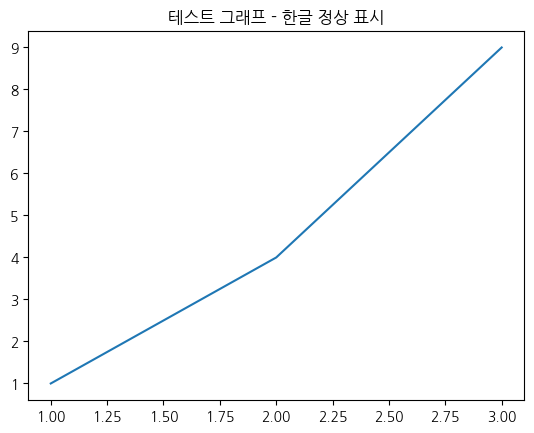

In [2]:
# @title
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Nanum" in font:
        print(font)


font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"


from matplotlib import font_manager
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()  # 실제 패밀리명 얻기
mpl.rcParams["font.family"] = font_name
mpl.rcParams["axes.unicode_minus"] = False

print("사용 폰트:", font_name)

plt.plot([1,2,3],[1,4,9])
plt.title("테스트 그래프 - 한글 정상 표시")
plt.show()

In [3]:
# @title


# 파일 불러오기
# 사용하는 환경에 따라 주석처리 해서 사용
df = pd.read_csv("ai_job_market.csv") # 주피터 용
# df = pd.read_csv("/content/ai_job_market.csv") # 코랩 용
# 코랩에서 사용할때는 csv파일 업로드 해주셔야 합니다.

# 전처리
'''
컬럼 지정, salary_range_usd "-" 뒤의 값 삭제, posted_date 날짜 삭제, location ','앞의 값 삭제(도시 제거),
skills_required, tools_preferred 리스트 화, experience_level, employment_type, company_size 코드 지정
'''
# 사용할 컬럼 지정
use_cols = (['industry', 'job_title', 'skills_required',
       'experience_level', 'employment_type', 'location', 'salary_range_usd',
       'posted_date', 'company_size', 'tools_preferred'])
df = df[use_cols].copy()

# salary_range_usd "-" 뒤의 값 삭제 - 앞의 숫자 초봉이라 가정
df['salary_range_usd'] = df['salary_range_usd'].str.replace('-[^-]*$', '', regex=True)

# posted_date 날짜 삭제
df['posted_date'] = df['posted_date'].str.replace('-[^-]*$', '', regex=True)

# location ','앞의 값 삭제(도시 제거)
df['location'] = df['location'].str.replace('.*,', '', regex=True)

# skills_required 리스트 화
# df['skills_required'] = (
#     df['skills_required']
#     .dropna()       # 결측치 제거
#     .apply(lambda x: [skill.strip() for skill in x.split(',')])  # 공백 제거 후 리스트화
# )

# tools_preferred 리스트 화
df['tools_preferred'] = (
    df['tools_preferred']
    .dropna()       # 결측치 제거
    .apply(lambda x: [skill.strip() for skill in x.split(',')])  # 공백 제거 후 리스트화
)

# experience_level 코드화 {Entry(신입): 0, Mid(경력): 1, Senior(시니어): 3}
df["experience_level"] = df["experience_level"].map({"Entry": 0, "Mid": 1, 'Senior': 2})

# employment_type 코드화 {Contract(계약직): 0, Remote(프리렌서): 1, Internship(인턴십): 2, , Full-time(정규직): 3}
df["employment_type"] = df["employment_type"].map({"Contract": 0, "Remote": 1, 'Internship': 2, 'Full-time': 3})

# company_size 코드화 {Startup(스타트업): 0, Mid(중소기업): 1, Large(대기업): 2}
df["company_size"] = df["company_size"].map({"Startup": 0, "Mid": 1, 'Large': 2})

In [4]:
# 훈련 R²: 0.982, 테스트 R²: 0.865

df_orig = df.copy()

def run_rf(df_input):
    df = df_input.copy()

    # --- skills 및 multi-hot ---
    df['skills_unique'] = df['skills_required'].apply(lambda x: x if isinstance(x, list) else (x.split(',') if isinstance(x, str) else []))
    top_skills = pd.Series([s for sub in df['skills_unique'] for s in sub]).value_counts().head(10).index.tolist()
    for s in top_skills: df[s] = df['skills_unique'].apply(lambda x: int(s in x))

    # --- 연도/경력 ---
    df['year'] = pd.to_datetime(df['posted_date'], errors='coerce').dt.year.fillna(0).astype(int)
    df['experience_level_num'] = df['experience_level']

    # --- location one-hot ---
    if 'location' in df.columns:
        df = pd.get_dummies(df, columns=['location'], dummy_na=False)

    # --- tools multi-hot ---
    tools = [t for sub in df['tools_preferred'] if isinstance(sub, list) for t in sub]
    top_tools = pd.Series(tools).value_counts().head(10).index.tolist()
    for t in top_tools: df['tool_'+t] = df['tools_preferred'].apply(lambda x: int(t in x if isinstance(x, list) else False))

    # --- feature/target ---
    feature_cols = top_skills + ['year','experience_level_num'] + [c for c in df.columns if c.startswith('company_size_') or c.startswith('employment_type_') or c.startswith('location_') or c.startswith('tool_')]
    X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
    y = pd.DataFrame({s+'_salary': df['salary_range_usd'].astype(float)*df[s] for s in top_skills})

    # --- train/test split + 학습 ---
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)).fit(X_train,y_train)

    # --- 예측 & R²(결정계수) ---
    y_train_pred, y_test_pred = rf.predict(X_train), rf.predict(X_test)
    print(f"훈련 R²: {r2_score(y_train, y_train_pred):.3f}, 테스트 R²: {r2_score(y_test, y_test_pred):.3f}")

    # --- 연도/경력별 평균 ---
    summary = X_test[['year','experience_level_num']].copy()
    for col in y_test.columns: summary[col] = y_test_pred[:,y_test.columns.get_loc(col)]
    grouped = summary.groupby(['year','experience_level_num']).mean()
    print("\n연도/경력별 기술별 평균 예측값\n", grouped)

    # --- 간단 분석 ---
    avg_salary_per_skill = y_test_pred.mean(axis=0)
    print("\n기술별 평균 예상 연봉:")
    for s,val in zip(y_test.columns, avg_salary_per_skill):
        print(f"{s}: {val:.0f} USD")

    return rf, y_train_pred, y_test_pred, y_test

# --- 실행 ---
rf_model, y_train_pred, y_test_pred, y_test_rf = run_rf(df_orig)


훈련 R²: 0.982, 테스트 R²: 0.865

연도/경력별 기술별 평균 예측값
                            TensorFlow_salary  Pandas_salary  Excel_salary  \
year experience_level_num                                                   
2023 0                           8136.628667   18563.364000  12281.946000   
     1                          18007.212500   18966.912857  17389.030714   
     2                          19160.595455   13017.593636  16360.594091   
2024 0                          15478.215755   19499.738679  17492.099245   
     1                          21170.788350   18840.552621  15422.804078   
     2                          20689.490753   18532.523333  16460.350215   
2025 0                          15486.430000   18691.404750  14068.143500   
     1                          26603.064507   21486.988873  11795.070000   
     2                          19438.740000   15708.709403   9635.382687   

                             GCP_salary  Scikit-learn_salary  Azure_salary  \
year experience_level_num 